In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from sklearn.model_selection import KFold
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt
import multiprocess
from sklearn.metrics import accuracy_score, classification_report



Create reproducible results

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)


In [3]:
num_processes = multiprocess.cpu_count()

print("Number of cpu : ", num_processes)
pool = multiprocess.Pool(processes=num_processes - 4)

Number of cpu :  8


In [4]:
# Datasets Path
TR_PATH_1 = "./monks/datasets/monks-1.train"
TS_PATH_1 = "./monks/datasets/monks-1.test"
# Datasets Path
TR_PATH_2 = "./monks/datasets/monks-2.train"
TS_PATH_2 = "./monks/datasets/monks-2.test"
# Datasets Path
TR_PATH_3 = "./monks/datasets/monks-3.train"
TS_PATH_3 = "./monks/datasets/monks-3.test"

In [5]:

def plot_graph(train_losses,losses,epochs,title):
    print(len(losses))
    print(len(train_losses))

    num_epochs = list(range(0, epochs))  
    print(len(num_epochs))
    # Plotting
    plt.plot(num_epochs, train_losses, label=' Training Loss ')
    plt.plot(num_epochs, losses, label=title+' Loss')

    plt.title('Training and '+title+' Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size,):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [7]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [8]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [9]:
def Padding(validation_losses_fold,train_losses_fold):
    max_epochs = max(map(len, validation_losses_fold))

    for validation_loss_arr in validation_losses_fold:
        while len(validation_loss_arr) < max_epochs:
            validation_loss_arr.append(validation_loss_arr[-1])

    for train_loss_arr in train_losses_fold:
      while len(train_loss_arr) < max_epochs:
            train_loss_arr.append(train_loss_arr[-1])

    print(len(validation_losses_fold))
    return validation_losses_fold,train_losses_fold

In [10]:
def Mean(validation_avg_loss_fold,train_losses_fold):
    max_epochs = max(map(len, validation_avg_loss_fold))
    validation_avg_loss = []
    train_avg_loss = []
    
    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(validation_avg_loss_fold)):
            temp_loss += validation_avg_loss_fold[j][i]
        validation_avg_loss.append(temp_loss)

    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(train_losses_fold)):
            temp_loss += train_losses_fold[j][i]
        train_avg_loss.append(temp_loss)
    
    return validation_avg_loss,train_avg_loss
    

    

In [11]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    # Use the GPU, if possible
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
        network = nn.DataParallel(network)
    network.to(device)

    # Initialize optimizer
    if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    train_losses = []
    test_losses = []

    tolerance_stopper = ToleranceStopper(patience=20, min_delta=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      epoch_train_accuracy = []


      # Set current loss and accuracy value for test
      test_loss = 0.0
      epoch_test_accuracy = []

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32).to(device)
        targets = data[:, [0]].to(torch.float32).to(device)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(epoch_train_loss)
      # Update accuracy
      for output, target in zip(outputs, targets):
        output = 0 if output.item() < 0.5 else 1
        if output == target.item():
          epoch_train_accuracy.append(1)
        else:
          epoch_train_accuracy.append(0)
      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32).to(device)
          targets = data[:, [0]].to(torch.float32).to(device)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)

        epoch_test_loss = test_loss / len(testloader.sampler)    
        test_losses.append(epoch_test_loss)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_test_accuracy.append(1)
          else:
            epoch_test_accuracy.append(0)
        print(epoch_test_loss)
        if tolerance_stopper.tol_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_losses,test_losses,epoch+1,"test")
    return network


In [12]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader,l1_lambda=0,retrain=False):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    # Initialize optimizer
    '''if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)'''

    tolerance_stopper = ToleranceStopper(patience=20, min_delta=1e-4)
    train_losses = []
    validaition_losses = []
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        if(l1_lambda > 0):
          l1_norm = sum(torch.linalg.norm(p, 1) for p in network.parameters())
          loss = loss + l1_lambda * l1_norm
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        #print("loss per item", loss.item())
        #print("inputs size",inputs.size(0))

        # Print loss values
      #print("train loaders length",len(trainloader.sampler.indices))

      avg_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(avg_train_loss) 
      #print(f'Training loss: {avg_train_loss}')
      # Print about testing
      #print('Starting validation')

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          #print("loss per item", loss.item())
          #print("inputs size",inputs.size(0))
        
        #print("validation loaders length",len(validationloader.sampler.indices))

        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        validaition_losses.append(avg_valid_loss)
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')


    '''if(retrain == True):
      plot_graph(train_losses,validaition_losses,epoch,"validation")'''
    return avg_valid_loss,avg_train_loss,validaition_losses,train_losses


In [13]:
def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay,l1_lambda,retrain=False):
    
    validation_avg_loss_fold = 0
    train_avg_loss_fold = 0
    validation_losses_fold = []
    train_losses_fold = []
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
 
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss,train_loss,validation_losses,train_losses = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader,l1_lambda = l1_lambda,retrain=retrain)   
        validation_avg_loss_fold  += validation_loss
        train_avg_loss_fold += train_loss
        validation_losses_fold.append(validation_losses)
        train_losses_fold.append(train_losses)

        num_iterations += 1


    #validation average over all folds
    validation_avg_loss_fold /= num_iterations
    
    validation_losses_fold,train_losses_fold = Padding(validation_losses_fold,train_losses_fold)

    validation_losses_mean, train_losses_mean = Mean(validation_losses_fold, train_losses_fold)
    
   # plot_graph(train_losses_mean,validation_losses_mean,len(validation_losses),"validation")


    return (validation_avg_loss_fold,train_avg_loss_fold,current_config)

function that executes the folds for each combination of parameters

In [14]:
def dogridsearch(dataset_train_part,params_grid,output_size,input_size):
    
    dataset = dataset_train_part
    # Set fixed random number seed
    loss_function = nn.MSELoss()

    # Define the K-fold Cross Validator
    kfold = CV 
    
    # K-fold Cross Validation model evaluation
    best_params = None

    actual_it = 0
    total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"]) * len(params_grid["l1_lambda"])


    configurations = []

    for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum,l1_lambda in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"],params_grid["l1_lambda"]):
        #print the actual percentage of the grid search
        print(f'Actual iter {(actual_it/total_iterations)*100}%')

        (validation_avg_loss_fold,train_avg_loss_fold,current_config) = execute_folds(kfold=kfold,dataset=dataset,learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                        ,opt=opt,output_size=output_size,weight_decay=weight_decay,batch_size=batch_size,l1_lambda=l1_lambda)


        configurations.append((validation_avg_loss_fold, train_avg_loss_fold,current_config))
        
        actual_it += 1


    #best 
    for conf_val in configurations:
        if best_params is None or conf_val[0] < best_params[0]:
                current_config = conf_val[2]
                best_params = (conf_val[0],conf_val[1]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])

    return best_params

test the created model and plot training/test error

In [15]:
def train_test_model(dataset_train_part,dataset_test_part,best_params):
    train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

    trainloader = torch.utils.data.DataLoader(
                        dataset_train_part, 
                        batch_size=best_params[9], sampler=train_subsampler)

    test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
    testloader = torch.utils.data.DataLoader(
                        dataset_test_part, 
                        batch_size=best_params[9], sampler=test_subsampler)

    best_net = fit_model(learning_rate=best_params[2],epochs=best_params[3],hidden_size=best_params[5],input_size=17,loss_function=best_params[4],
                        momentum=best_params[6],opt=best_params[7],output_size=1,trainloader=trainloader,weight_decay=best_params[8],testloader=testloader)   
    return best_net

In [16]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]
}
    

dataset_train_part = read_ds(TR_PATH_1)
dataset_test_part = read_ds(TS_PATH_1)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%
Early stopping: 139
Early stopping: 75
Early stopping: 49
Early stopping: 49
Early stopping: 49
5


monk 1:
Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0022038360655424185, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)

In [17]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.02802503627706892, 0.051876862066632695, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Starting epoch 1
0.20074814847773975
Starting epoch 2
0.1991359175407086
Starting epoch 3
0.19492932082222844
Starting epoch 4
0.17815734762525945
Starting epoch 5
0.16603100067004561
Starting epoch 6
0.15783851462226636
Starting epoch 7
0.18955511173785286
Starting epoch 8
0.14246258594707964
Starting epoch 9
0.12490378578917848
Starting epoch 10
0.09878362381951539
Starting epoch 11
0.08854176847941105
Starting epoch 12
0.031165780911342828
Starting epoch 13
0.015167934622796666
Starting epoch 14
0.01081223083774266
Starting epoch 15
0.008523394830128248
Starting epoch 16
0.007453072950873455
Starting epoch 17
0.00608242796658521
Starting epoch 18
0.005399343846538277
Starting epoch 19
0.004611142682767456
Starting epoch 20
0.004039567019828138
Starting epoch 21
0.0036947484294176792
Starting epoch 22
0.003282386234921567
Starting epoch 23
0.0030985979855931538
Starting epoch 24
0.0027750167700341315
Starting epoch 25
0.002633651743895758
Starting epoch 26
0.002400002816473177
Starti

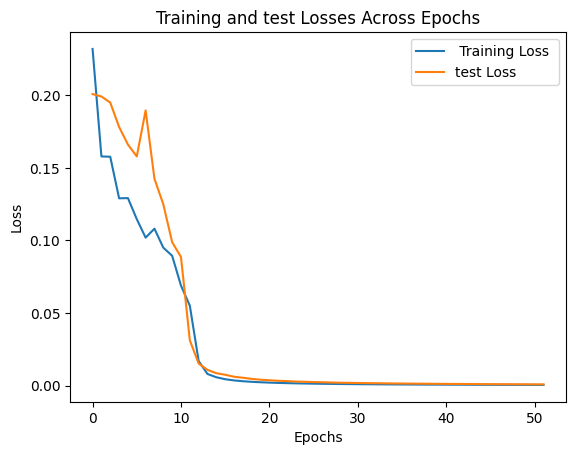

In [18]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



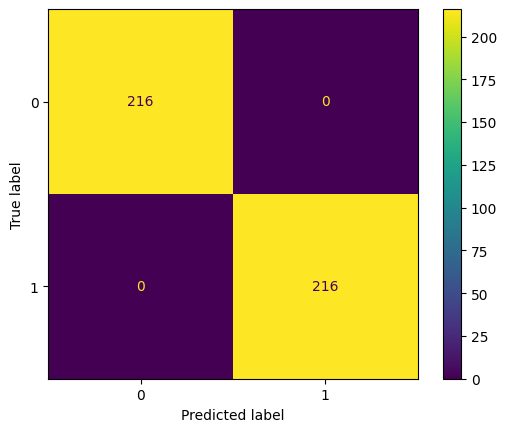

------------------------------------------------------------------------------------------------------


In [19]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 2

In [20]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]

}
    

dataset_train_part = read_ds(TR_PATH_2)
dataset_test_part = read_ds(TS_PATH_2)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%
Early stopping: 40
Early stopping: 55
Early stopping: 43
Early stopping: 153
Early stopping: 41
5


In [21]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.029068782699506364, 0.0408365739268897, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Starting epoch 1
0.22470146114075626
Starting epoch 2
0.26077604983691816
Starting epoch 3
0.22678995960288578
Starting epoch 4
0.25363596259719795
Starting epoch 5
0.2113184951659706
Starting epoch 6
0.19901288942330414
Starting epoch 7
0.210808755243542
Starting epoch 8
0.23364544128438597
Starting epoch 9
0.1578221215383598
Starting epoch 10
0.09478339535417035
Starting epoch 11
0.010574844786552367
Starting epoch 12
0.006413185178341034
Starting epoch 13
0.004518948323998807
Starting epoch 14
0.0038473063051006414
Starting epoch 15
0.003181333324324374
Starting epoch 16
0.0027925539561019157
Starting epoch 17
0.0024029223546946283
Starting epoch 18
0.0021293824138410855
Starting epoch 19
0.0019049414252178933
Starting epoch 20
0.0017469302259727286
Starting epoch 21
0.001608905578231551
Starting epoch 22
0.0014868185306921885
Starting epoch 23
0.0013679727255496094
Starting epoch 24
0.0012799710375138264
Starting epoch 25
0.0012099306885728664
Starting epoch 26
0.001137340673907332

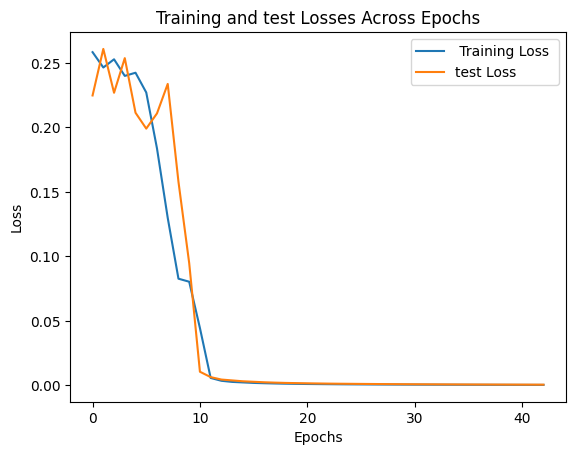

In [22]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



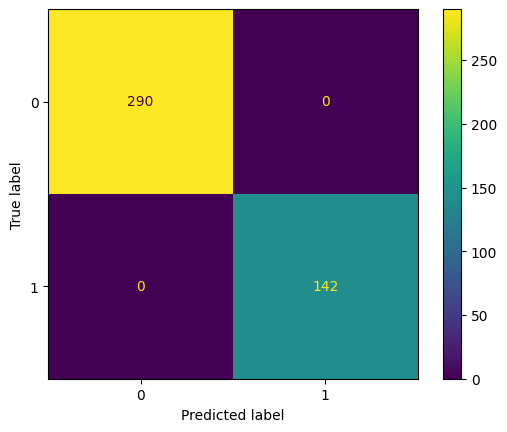

------------------------------------------------------------------------------------------------------


In [23]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 3

In [24]:
input_size = 17  
output_size = 1
params_grid = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0.6,0.8,0.9],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0.1,0.2,0,0.5]

}


params_grid_sp = {
    "hidden_size": [5],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0.9],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0.5]
}
    

dataset_train_part = read_ds(TR_PATH_3)
dataset_test_part = read_ds(TS_PATH_3)

dataset = dataset_train_part
best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        

'''
init_seeds = list(range(5,10))
best_models_params = []

for init_seed in init_seeds:
  torch.manual_seed(init_seed)
  best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
  best_models_params.append((best_params,init_seed))

for best_param,init_seed in best_models_params:
  torch.manual_seed(init_seed)
  print(init_seed)
  execute_folds(learning_rate=best_param[2],epochs=best_param[3],hidden_size=best_param[5],input_size=input_size,loss_function=best_param[4],momentum=best_param[6]
                                                    ,opt=best_param[7],output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader,l1_lambda = l1_lambda)


da togliere riga sotto

best_params = (conf_val[0],conf_val[1]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])
'''














'''#TODO per ogni seed prendi il miglior modello dopo gridsearch e scegli quello che minimizza la loss di validazione


for init_seed in init_seeds:
  torch.manual_seed(init_seed)
  best_model, train_losses, valid_losses = gridsearchCV('monks-2.train', hyperparameters_m2)
  best_models.append((best_model, seed, train_losses, valid_losses))

# Train and test the best neural networks we found using different weights initializations
for (parameters, seed, tr_loss, vl_loss) in best_models:
  torch.manual_seed(seed)
  model = train_net('monks-2.train', 'monks-2.test', parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5])
  print(f"parameters: {parameters}")
  print(f'seed: {seed}')
  print(f"avg(tr_loss): {sum(tr_loss)/len(tr_loss)}, std(tr_loss): {np.std(tr_loss)}")
  print(f"avg(vl_loss): {sum(vl_loss)/len(vl_loss)}, std(vl_loss): {np.std(vl_loss)}\n\n")
  filename = "monks2-"+str(seed)+".pt"
  torch.save(model.state_dict(), filename)
'''




Actual iter 0.0%


Early stopping: 23
Early stopping: 20
Early stopping: 20
Early stopping: 21
Early stopping: 20
5
Actual iter 0.034722222222222224%
Early stopping: 21
Early stopping: 22
Early stopping: 20
Early stopping: 20
Early stopping: 20
5
Actual iter 0.06944444444444445%
Early stopping: 20
Early stopping: 29
Early stopping: 20
Early stopping: 21
Early stopping: 21
5
Actual iter 0.10416666666666667%
Early stopping: 21
Early stopping: 26
Early stopping: 20
Early stopping: 20
Early stopping: 20
5
Actual iter 0.1388888888888889%
Early stopping: 23
Early stopping: 23
Early stopping: 20
Early stopping: 20
Early stopping: 21
5
Actual iter 0.1736111111111111%
Early stopping: 23
Early stopping: 21
Early stopping: 20
Early stopping: 21
Early stopping: 21
5
Actual iter 0.20833333333333334%
Early stopping: 20
Early stopping: 24
Early stopping: 20
Early stopping: 21
Early stopping: 20
5
Actual iter 0.24305555555555555%
Early stopping: 21
Early stopping: 20
Early stopping: 21
Early stopping: 20
Early stopping:

'#TODO per ogni seed prendi il miglior modello dopo gridsearch e scegli quello che minimizza la loss di validazione\n\n\nfor init_seed in init_seeds:\n  torch.manual_seed(init_seed)\n  best_model, train_losses, valid_losses = gridsearchCV(\'monks-2.train\', hyperparameters_m2)\n  best_models.append((best_model, seed, train_losses, valid_losses))\n\n# Train and test the best neural networks we found using different weights initializations\nfor (parameters, seed, tr_loss, vl_loss) in best_models:\n  torch.manual_seed(seed)\n  model = train_net(\'monks-2.train\', \'monks-2.test\', parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5])\n  print(f"parameters: {parameters}")\n  print(f\'seed: {seed}\')\n  print(f"avg(tr_loss): {sum(tr_loss)/len(tr_loss)}, std(tr_loss): {np.std(tr_loss)}")\n  print(f"avg(vl_loss): {sum(vl_loss)/len(vl_loss)}, std(vl_loss): {np.std(vl_loss)}\n\n")\n  filename = "monks2-"+str(seed)+".pt"\n  torch.save(model.state_dict(), filen

In [25]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 5 
Best learning rate: 0.4 
Best batch size: 32 
Best weight decay: 0.6 
Best momentum: 0.8
(0.24911287426948547, 7.1664848491916295, 0.4, 600, MSELoss(), 5, 0.8, <class 'torch.optim.sgd.SGD'>, 0.6, 32)


Starting epoch 1
0.2552753101896357
Starting epoch 2
0.24412809201964625
Starting epoch 3
0.24810614850785997
Starting epoch 4
0.25169512408751027
Starting epoch 5
0.24908775035981778
Starting epoch 6
0.24961811855987268
Starting epoch 7
0.2507731726876012
Starting epoch 8
0.2500321975460759
Starting epoch 9
0.24973176695682384
Starting epoch 10
0.2504421395284158
Starting epoch 11
0.2504807511965434
Starting epoch 12
0.24951190529046235
Starting epoch 13
0.25056066226076196
Starting epoch 14
0.24968208096645497
Starting epoch 15
0.25023848922164355
Starting epoch 16
0.25035701747293826
Starting epoch 17
0.24959200731030218
Starting epoch 18
0.2502552745518861
Starting epoch 19
0.2501169564547362
Starting epoch 20
0.2499261752322868
Starting epoch 21
0.2502842324751395
Starting epoch 22
0.2500515988579503
Early stopping:  21
22
22
22


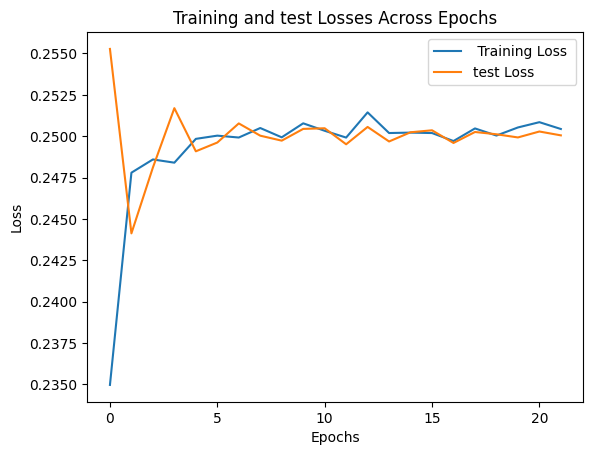

In [26]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 0.472
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       204
           1       0.00      0.00      0.00       228

    accuracy                           0.47       432
   macro avg       0.24      0.50      0.32       432
weighted avg       0.22      0.47      0.30       432



/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


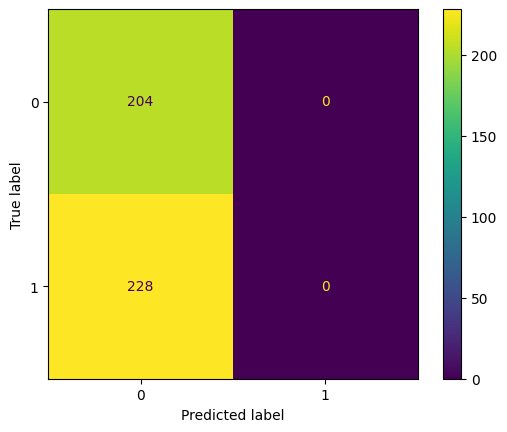

------------------------------------------------------------------------------------------------------


In [27]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
